# Near real-time burnt area mapping using the Digital Earth Africa datacube
* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a), [ls8_sr](https://explorer.digitalearth.africa/products/ls8_sr), [ls9_sr](https://explorer.digitalearth.africa/products/ls9_sr) 

## Background
This notebook shows an example of how to use Digital Earth Africa’s near real-time freely available imagery for users tracking recent fire events. This notebook outlines a workflow to select the most suitable ‘near real-time’ and baseline imagery for comparison from the Landsat 8 & 9 and Sentinel-2A & Sentinel-2B sensors. Thresholding is applied to detect unverified burnt areas, before creating an exportable polygon vector file.

**What does ‘Near Real-time’ Burnt Area Mapping mean?**

“Near real-time (NRT)” or “Rapid Mapping” within this context refers to satellite data or imagery from the Sentinel-2 and Landsat satellites that will be processed as soon as possible after the data is received by Digital Earth Africa. It can take a few days after an image is captured by a sensor to become available for analysis in the Digital Earth Africa Sandbox Environment. Although Digital Earth Africa makes every effort to make imagery available ASAP, unforeseen challenges may cause delays in image availability.

#### When to use this notebook
This notebook is designed to map the extent of fires within Africa over the previous fortnight dependent on the availability of suitable imagery. The output of this notebook does not measure the severity of fires.

For users interested in mapping historical fires, please use the [Burnt area mapping using Sentinel-2 data notebook](Burnt_area_mapping.ipynb) instead.

#### Normalised Burn Ratio (NBR) and delta Normalised Burn Ratio (dNBR)
The Normalised Burn Ratio (NBR) is a Fire Severity Index (FSI) that uses the differences in the way healthy green vegetation and burnt vegetation reflect light to detect burnt pixels in multi-spectral imagery. The NBR index requires signals from the NIR (Near Infrared) and SWIR (Short-wave Infrared) parts of the electromagnetic spectrum and is defined below.

\begin{equation}
\text{NBR} = \frac{(\text{NIR} - \text{SWIR})}{(\text{NIR} + \text{SWIR})}
\end{equation}

 
Comparing the most-recent NBR values to a baseline or past NBR (i.e. dNBR) can assist in removing noise and isolating environmental change in an EO workflow. The change in NBR is called the delta NBR (dNBR) and is defined as:

\begin{equation}
\text{dNBR} = \text{NBR}_{\text{baseline}} - \text{NBR}_{\text{post fire}}
\end{equation}

More information on NBR and dNBR can be found in the [Burnt area mapping using Sentinel-2 data notebook](Burnt_area_mapping.ipynb) instead.

#### Relativized Burn Ratio (RBR)
The Relativized Burn Ratio (RBR) is a variation of the Relativized delta Normalised Burn Ratio (RdNBR) developed by [Parks et al., 2014](https://www.mdpi.com/2072-4292/6/3/1827) that solves some of the numerical problems with the original RdNBR algorithm. Like the RdNBR, the RBR aims to improve burnt area mapping over burnt areas that had low levels of pre-fire vegetation by considering the baseline NBR measurement to prevent these areas being thresholded out.

\begin{equation}
\text{RBR} = \frac{dNBR}{(\text{NBR}_{\text{baseline}} + 1.001)}\end{equation}
 
Later on in this analysis, you may wish to use the RBR index instead of the dNBR index if your Area of Interest (AOI) has considerable amounts of burnt area that originally had low vegetation levels. For example, the RBR may work better mapping fires over AOI’s with both barren grasslands and dense canopies then the dNBR method.

### Description
1. This notebook contains the following steps:
2. Getting Started and Defining an Area of Interest (AOI)
3. Define suitable date ranges for the baseline and Near Real-time Images
4. Load, Visualise, and Select a Near Real-time image
5. Load and Select baseline Imagery
6. Calculate NBR and dNBR dataarray’s and perform optional post-processing
7. Convert raster data to vector and export products

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import math
import sys

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from scipy import ndimage
from datacube.utils import cog
from skimage import morphology
from datetime import datetime, timedelta
from datacube.utils.geometry import Geometry

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.spatial import xr_rasterize, xr_vectorize

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Burnt_area_mapping_near_realtime")

### Analysis parameters

The following cell sets the parameters, which define the area of interest to conduct the analysis over.
#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer, or separate latitude and longitude buffers, this method allows you to define an area of interest around a central point. You can input the central latitude, central longitude, and a buffer value in degrees to create a square area around the center point. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates `(10.338, -1.055)`. 
    
    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.
    
    For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers a fire event in an area within the southern Cape forestry area near George, South Africa. During late October and early November 2018, relatively dry weather conditions prevailed, creating favorable conditions for forest fires that destroyed extensive areas of plantation forests. Two wildfires occurred in succession: the first broke out due to human-induced ignition on October 24th, and the second was ignited by lightning on October 29th.

**To run the notebook for a different area**, make sure Sentinel-2 or Landsat 8 or 9 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).

In [3]:
# Method 1: Specify the latitude, longitude, and buffer)
aoi = define_area(lat=-33.8875, lon=22.569403, buffer=0.1)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

### Define suitable date ranges for the baseline and Near Real-time Images
By default, images from the previous 14 days from the current date are extracted from the datacube and visualised for manual selection. If a different NRT date range is desired, enter this for the `nrt_time_delta` variable in `DD` format.

For the selection of a baseline image, the default is to extract and visualise imagery that was acquired within the period extending between 14 days to two months prior to the current date. If a different date range is preferred, adjust the `baseline_time_delta` below in `DD` format.

The date ranges calculated below are a good starting point, but your chosen AOI may require larger or smaller date ranges.

**For the purpose of demonstrating the capability of this notebook during a fire event, a static date has been entered for the ``nrt_date_end`` variable. To run this notebook for a current fire, please instead run the second line of code noted below to set ``nrt_date_end`` to the current date.**

In [5]:
# Near Real-time event date '2018-11-12' is used to demonstrate the notebooks capabilities.
# For use mapping a current event, please move the '#' from the second to the first line below.
nrt_date_end = "2018-11-12"
# nrt_date_end = datetime.today().strftime("%Y-%m-%d")

In [6]:
# Define the date ranges for NRT and baseline imagery requests. The default is the preceding 14 days for
# NRT imagery, then the two months prior to that for baseline imagery.

nrt_time_delta = 14
baseline_time_delta = 42

# Calculate the beginning of the 'nrt' date range.
nrt_date_start = datetime.strftime(
    ((datetime.strptime(nrt_date_end, "%Y-%m-%d")) - timedelta(days=nrt_time_delta)),
    "%Y-%m-%d",
)
# Date range from which to extract and visualise potential baseline images. Can be manually changed by enterring a date in 'YYYY-MM-DD' format.
baseline_start = datetime.strftime(
    (
        (datetime.strptime(nrt_date_start, "%Y-%m-%d"))
        - timedelta(days=baseline_time_delta)
    ),
    "%Y-%m-%d",
)
baseline_end = datetime.strftime(
    ((datetime.strptime(nrt_date_end, "%Y-%m-%d")) - timedelta(days=nrt_time_delta)),
    "%Y-%m-%d",
)
# Print Date ranges
print(
    f"Potential Near Real-time Images will be extracted between {nrt_date_start} and {nrt_date_end}"
)
print(
    f"Potential baseline Images will be extracted between {baseline_start} and {baseline_end}"
)


Potential Near Real-time Images will be extracted between 2018-10-29 and 2018-11-12
Potential baseline Images will be extracted between 2018-09-17 and 2018-10-29


### Load, Visualise, and Select a Near Real-time image
The availability of cloud-free and recent imagery is the largest limiting factor in undertaking Burn Area Mapping in near real-time while a fire event occurs. Therefore, we will look at recent images from both the Sentinel-2 and Landsat imagery collections to maximise the change of finding a suitable image.

To reduce the impact of cross-sensor influence on our analysis, we will only load baseline imagery from the sensor from which our near real-time image is selected.

#### Define Load Parameters
NB: The `min_gooddata_nrt` and `min_gooddata_base` variables are used to filter out poor-quality images for the chosen AOI in the Near Real-time and Baseline Imagery extracts respectively. The values assigned to these variables set the threshold for the number of ‘good’ (i.e. cloud free) pixels required for the image to be extracted.

A `min_gooddata` value of 0.9 will ensure that only images with over 90% cloud free pixels over the AOI are extracted. To increase the number of images extracted, these values can be reduced to allow images with more cloudy pixels to be extracted.

In [7]:
# Set spatial, spectral, and quality parameters for the imgery extracrt from the datacube.

# Setting the min_gooddata value lower for the near real-time extract increases the number of images to chose from
min_gooddata_nrt = 0.6
min_gooddata_base = 0.8

# DIfferent measurements are required for each sensor due to changes in band nomenclature
measurements_s2 = [
    "blue",
    "green",
    "red",
    "nir_1",
    "swir_2",
]
measurements_ls = [
    "blue",
    "green",
    "red",
    "nir",
    "swir_2",
]

# Define the resolution tobe used for each sensor. The Sentinel-2 resolution can be reduced to 10m if desired.
s2_res = (-20, 20)
ls_res = (-30, 30)

# Define the coordinate system
output_crs = "EPSG:6933"

# Create a query object for the universal parameters
query = {
    "x": lon_range,
    "y": lat_range,
    "output_crs": output_crs,
    "group_by": "solar_day",
}

### Load images from the Sentinel-2 collection

In [8]:
# Load imagery from the Sentinel-2 Collection. Note the s2cloudless mask is applied instead of the standard fmask.
nrt_s2 = load_ard(
    dc=dc,
    products="s2_l2a",
    time=(nrt_date_start, nrt_date_end),
    measurements=measurements_s2,
    min_gooddata=min_gooddata_nrt,
    resolution=s2_res,
    **query
)

#Assign a custom attribute 'sensor' to the Sentinel-2 dataset for plotting purposes.
nrt_s2 = nrt_s2.assign_attrs({"sensor":"s2"})

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 5 out of 6 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Loading 5 time steps


### Load images from the Landsat collection

In [9]:
# Load imagery from the Landsat Collection.
nrt_ls = load_ard(
    dc=dc,
    products=["ls8_sr", "ls9_sr"],
    time=(nrt_date_start, nrt_date_end),
    measurements=measurements_ls,
    min_gooddata=min_gooddata_nrt,
    resolution=ls_res,
    **query
)

#Assign a custom attribute 'sensor' to the Landsat dataset for plotting purposes.
nrt_ls = nrt_ls.assign_attrs({"sensor":"ls"})

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
    ls9_sr
Counting good quality pixels for each time step
Filtering to 1 out of 2 time steps with at least 60.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 1 time steps


### Near Real-time Image Visualisation

Images from both the Sentinel-2 and Landsat collections that met the spatial, temporal, and quality requirements we previously defined will be visualised below. Make note of the date, index number and sensor of each image located in the subplot title.

In the next step, we will need to set the `nrt_img_index` and `nrt_sensor` variables to the chosen images index and sensor respectively.

**It is not uncommon for no suitable landsat images to have been acquired that meet the near real-time requirements in the previous 14 days. If this occurs, the notebook will continue to run without issue.**

#### Define `plot_variable_images` function
The `plot_variable_images` function dynamically plots images from an xarray dataset containing RGB bands, with titles displaying the date and index, and optionally the sensor type if specified. It first checks that the input is a valid xarray dataset and calculates the number of images. If no images are present, it raises an error. The function determines the necessary number of subplot rows, creates the subplots, and iterates through each image to plot it as an RGB image, ensuring robust color scaling.

In [10]:
def plot_variable_images(img_collection):
    # Check that img_collection is a xarray dataset
    if not isinstance(img_collection, xr.Dataset):
        raise TypeError("img_collection must be a xarray dataset.")

    # Calculate number of images in `img_collection`
    plot_count = img_collection.dims["time"]
    
    # Check if dataset has 0 images
    if plot_count == 0:
        if hasattr(img_collection, "sensor"):
            raise ValueError("The {} dataset has no images to display for the " 
            "given query parameters".format(img_collection.sensor))
        else:
            raise ValueError("The supplied xarray dataset has no images to "
            "display for the given query parameters")
                  
    # Divide the number of images by 2 rounding up to calculate the
    # number of rows for the below figure are needed
    plot_rows = math.ceil(plot_count / 2)

    # Construct a figure to visualise the imagery
    f, axarr = plt.subplots(plot_rows, 2, figsize=(10, plot_rows * 4.5),
                            squeeze=False)

    # Flatten the subplots so they can easily be enumerated through
    axarr = axarr.flatten()

    # Iterate through each image in the dataset and plot
    # each image as a RGB on a subplot
    for t in range(plot_count):
        rgb(
            img_collection.isel(time=t),
            bands=["red", "green", "blue"],
            ax=axarr[t],
            robust=True,
        )
        # Test to see if the dataset has a custom 'sensor' attribute.
        # If so, include the string in each subplot title.
        if hasattr(img_collection, "sensor"):
            title = (
                str(img_collection.time[t].values)[:10]
                + "  ||  Index: "
                + str(t)
                + "  ||  Sensor: "
                + img_collection.sensor
            )
        else:
            title = (
                str(img_collection.time[t].values)[:10]
                + "  ||  Index: "
                + str(t)
            )
        # Set subplot title, axis label, and shrink offset text
        axarr[t].set_title(title)
        axarr[t].set_xlabel("X coordinate")
        axarr[t].set_ylabel("Y coordinate")
        axarr[t].yaxis.offsetText.set_fontsize(6)
        axarr[t].xaxis.offsetText.set_fontsize(6)

    # Adjust padding arround subplots to prevent overlapping elements
    plt.tight_layout()

    # Remove the last subplot if an odd number of images are being displayed
    if plot_count % 2 != 0:
        f.delaxes(axarr[plot_count])

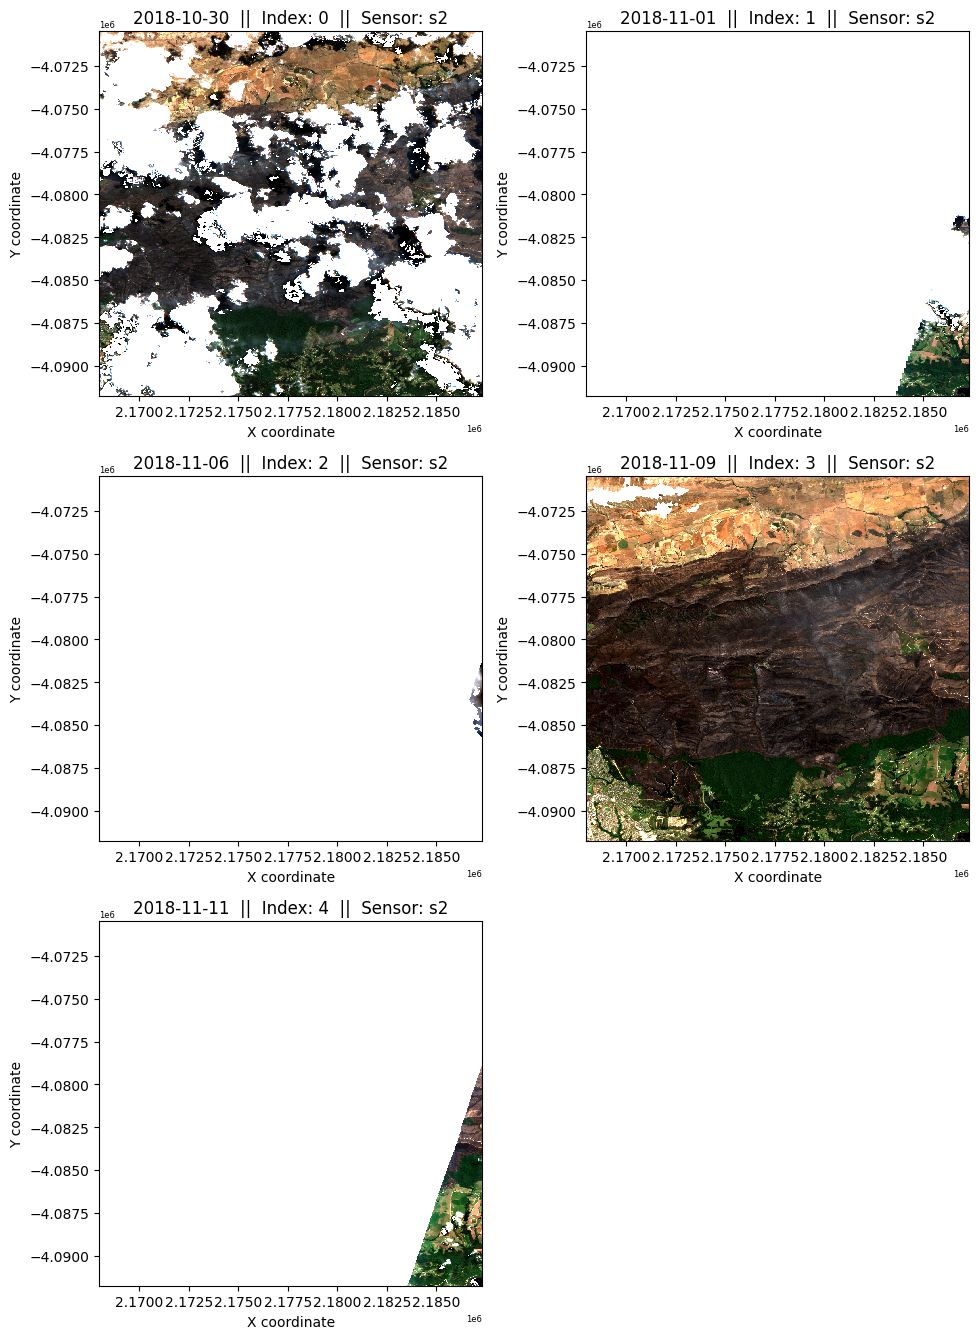

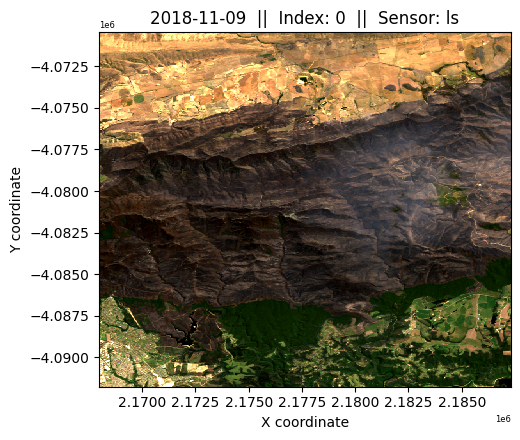

In [11]:
#Plot imagery from the Sentinel-2 satellites by running the `plot_variable_images` tool on the `nrt_s2` xarray dataset.
plot_variable_images(nrt_s2)

#Plot suitable imagery from the Landsat satellites by running the `plot_variable_images` tool on the `nrt_ls` xarray dataset.
if nrt_ls.time.size == 0:
    print('No suitable Landsat imagery')
else:
    plot_variable_images(nrt_ls)

### Near Real-time Image Selection
> Looking at the near real-time (NRT) images available from both Sentinel-2 and Landsat, the Landsat image appears to be the most suitable option for further analysis. Although there is a single Sentinel-2 image (Index: 3) with a higher spatial resolution, it has more gaps than the available Landsat image. The Landsat image provides a clearer view with fewer gaps, making it more appropriate for detailed analysis and interpretation. Therefore, the Landsat image is chosen for its superior spatial coverage.

> For the baseline image selection process which occurs a few cells down in the code, imagery from the sensor of the selected NRT image will be loaded. If a Sentinel-2 NRT image is selected, then Sentinel-2 imagery will be loaded for selection of the baseline image. Similarly, if a Landsat NRT image is chosen, then Landsat imagery will be loaded for selection. This ensures continuity and consistency in the dataset, facilitating accurate comparison and analysis between the NRT and baseline periods

From the above images, note the index value of the most appropriate scene and set the `nrt_img_index` variable below to that value. For example, if the first image displayed is the most desirable, set `nrt_img_index = 0`.

Additionally, set the rt_sensor variable to the sensor that the chosen near real-time image originated from, s2 for Sentinel-2 or ls for Landsat. Only imagery from the selected collection will be displayed for the baseline image visualisaion below to reduce cross-sensor influence on the analysis.

In [12]:
# Index selection for the Near Real-time image chosen above. The default value of -1 selects the most recent image regardless of suitability.
nrt_img_index = 0
# Set the below variable to either 's2' or 'ls' depending on the sensor your chosen image is from.
nrt_sensor = "ls"

# Assign the selected image to the rt_img variable, and identify which sensor and measurements to use to find a baseline image.
if nrt_sensor == "s2":
    nrt_img = nrt_s2.isel(time=nrt_img_index)
    baseline_products = "s2_l2a"
    baseline_measurements = measurements_s2
    index_collection = "s2"
    baseline_res = s2_res
elif nrt_sensor == "ls":
    nrt_img = nrt_ls.isel(time=nrt_img_index)
    baseline_products = ["ls8_sr", "ls9_sr"]
    baseline_measurements = measurements_ls
    index_collection = "c2"
    baseline_res = ls_res
else:
    print(
        "Please make sure the 'nrt_sensor' variable is correctly set to either s2 or ls"
    )

### Load and Select baseline Imagery

In [13]:
# Load imagery from whichever collection the NRT image was selected from.
baseline = load_ard(
    dc=dc,
    products=baseline_products,
    time=(baseline_start, baseline_end),
    measurements=baseline_measurements,
    min_gooddata=min_gooddata_base,
    resolution=baseline_res,
    **query
)

#Assign a custom attribute 'sensor' to the baseline dataset for plotting purposes.
baseline = baseline.assign_attrs({"sensor": nrt_sensor})

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
    ls9_sr
Counting good quality pixels for each time step
Filtering to 3 out of 5 time steps with at least 80.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 3 time steps


### Visualise the extracted baseline imagery

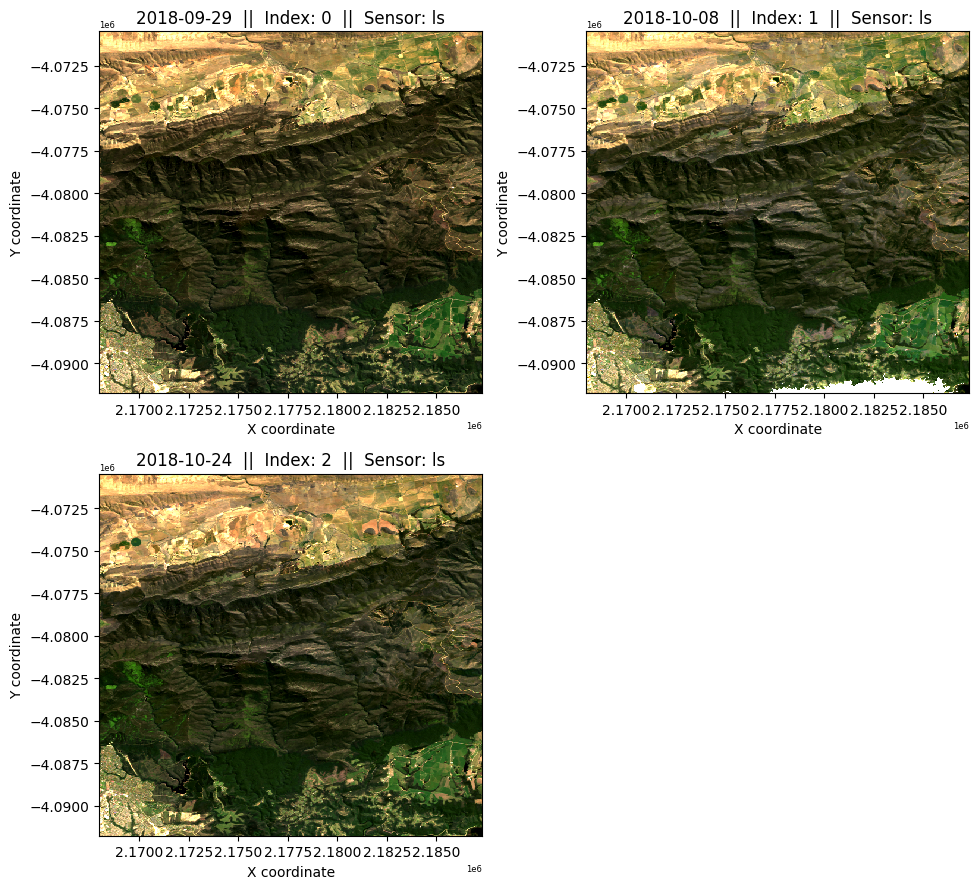

In [14]:
#Plot imagery from the baseline dataset by running the `plot_variable_images` tool on the `baseline` xarray dataset.
plot_variable_images(baseline)

### Baseline Image Selection
A baseline image from the above selection must be chosen. It is important to remember that the dNBR index measured environmental changes associated with fire induced landscape change. Therefore, a scene similar to the near real-time image that is free from fire affects will provide the best comparison point to detect burn scars. For example, if the landscape in the near real-time image is dry, it is better to chose a baseline image where the landscape has a similar level of dryness compared to a greener image.

Note the index number of the baseline image chosen above, then set it to the baseline_img_index variable.

In [15]:
# Set the baseline_img_index variable to the index of the chosen baseline image
baseline_img_index = 0

# Extract the chosen baseline image to the baseline_img variable
baseline_img = baseline.isel(time=baseline_img_index)

### Calculate NBR and dNBR dataarray’s and perform optional post-processing

In [16]:
# Calculate NBR for the near real-time image and assign it to the rt_NBR variable
nrt_image_NBR = calculate_indices(
    nrt_img, index="NBR", collection=index_collection, drop=False
)
nrt_NBR = nrt_image_NBR.NBR

# Calculate NBR for the baseline image and assign it to the baseline_NBR variable
baseline_image_NBR = calculate_indices(
    baseline_img, index="NBR", collection=index_collection, drop=False
)
baseline_NBR = baseline_image_NBR.NBR

# Calculate dNBR (delta NBR) by differeing the two indices
dNBR = baseline_NBR - nrt_NBR

Text(0.5, 1.0, 'Baseline NBR 2018-09-29')

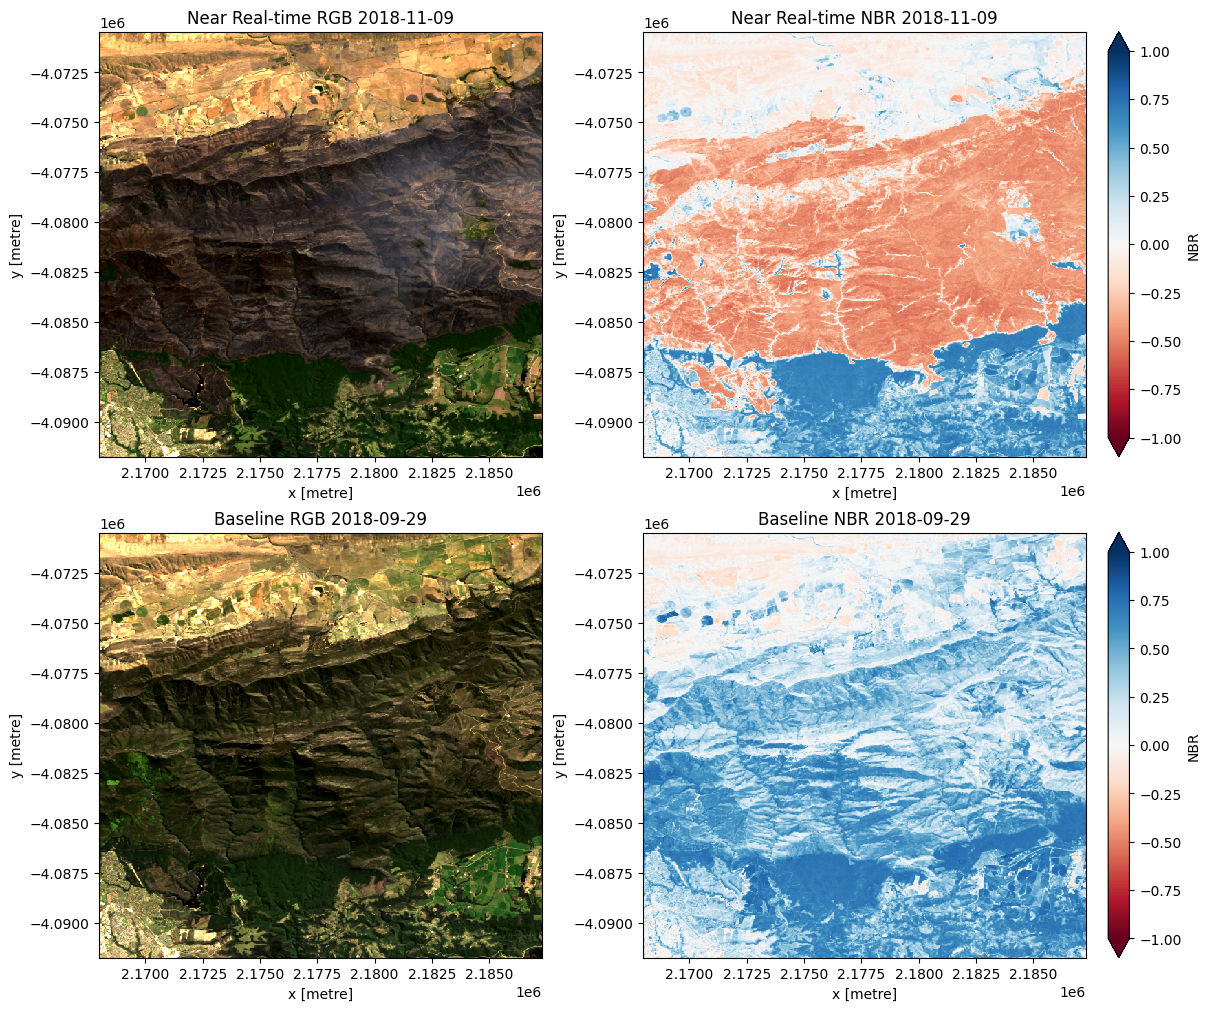

In [17]:
# Create a figure to visualise the selected images in true colour, as well as the NBR index.
f, axarr = plt.subplots(2, 2, figsize=(12, 10), squeeze=False, layout="constrained")

# Visualise the selected near real-time and baseline images in true colour
rgb(
    nrt_img,
    bands=["red", "green", "blue"],
    ax=axarr[0, 0],
    robust=True,
)

rgb(
    baseline_img,
    bands=["red", "green", "blue"],
    ax=axarr[1, 0],
    robust=True,
)

# Visualise the NBR index for each image
nrt_NBR.plot(cmap="RdBu", vmin=-1, vmax=1, ax=axarr[0, 1])

baseline_NBR.plot(cmap="RdBu", vmin=-1, vmax=1, ax=axarr[1, 1])

# Set subplot Titles
axarr[0, 0].set_title("Near Real-time RGB " + str(nrt_img.time.values)[:10])
axarr[0, 1].set_title("Near Real-time NBR " + str(nrt_img.time.values)[:10])
axarr[1, 0].set_title("Baseline RGB " + str(baseline_img.time.values)[:10])
axarr[1, 1].set_title("Baseline NBR " + str(baseline_img.time.values)[:10])

### dNBR vs RBR for Burnt Area Mapping
As previously discussed, two differenced fire severity indices are available in this notebook. Try using the dNBR index in the first instance. However, if the fire in your AOI occurs over less densely vegetated landscapes such as grasslands, you may wish to trial the RBR index. In this example, we have used the RBR index as the fire has occurred over substantial amounts of grass dominated areas.

Depending on your choice of Fire Severity Index, set the `bam_method` variable to either ‘dNBR’ or ‘RBR’.

In [18]:
# set the bam_method variable to either 'dNBR' or 'RBR'.
bam_method = "RBR"

# Calculate the bam variable based on the chosen dFSI
if bam_method == "RBR":
    RBR = dNBR / (baseline_NBR + 1.001)
    bam = RBR

elif bam_method == "dNBR":
    bam = dNBR
else:
    print(
        "Please make sure the 'bam_method' variable is correctly set to either 'RBR' or 'dNBR'"
    )

#Rename the variable in the bam dataarray with the new dFSI
bam.name=(bam_method)


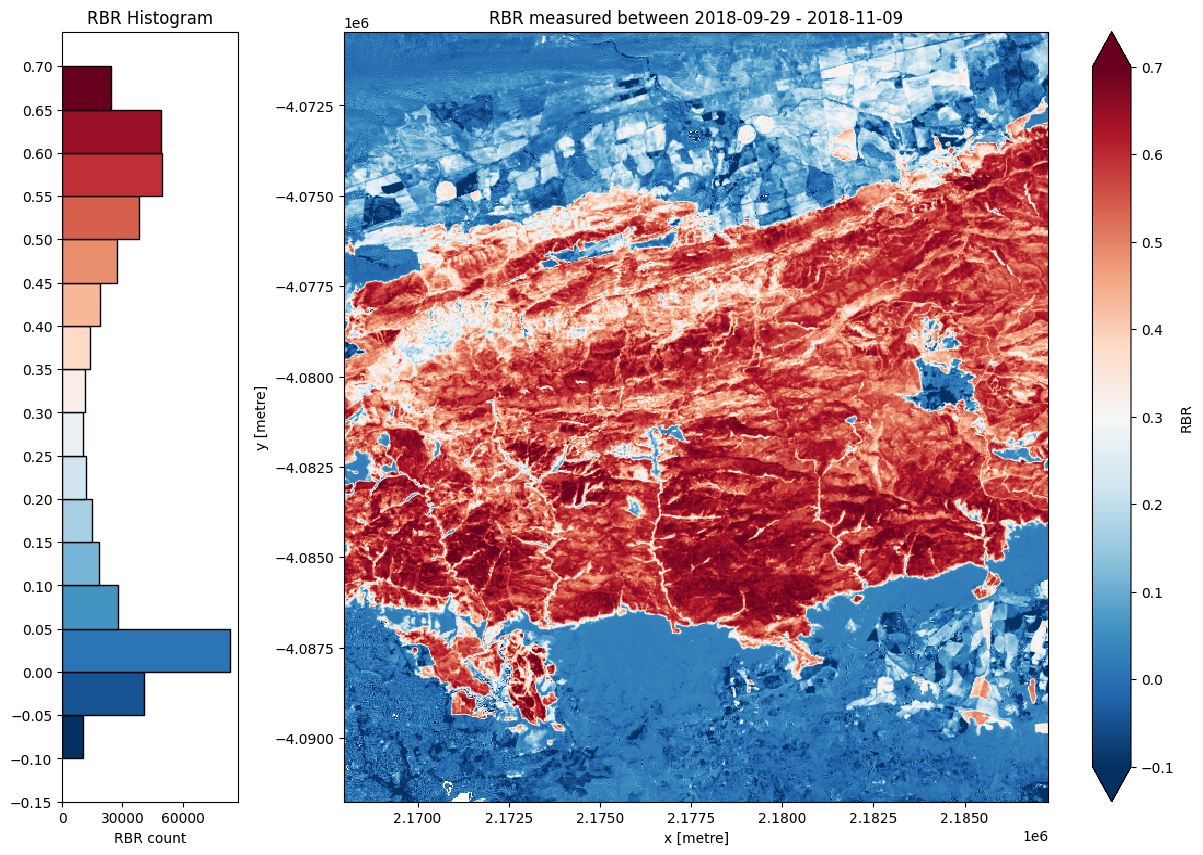

In [19]:
# Create a figure to plot the chosen fire severity index
f, axarr = plt.subplots(
    1, 2, figsize=(15, 10), squeeze=False, gridspec_kw={"width_ratios": [1, 5]}
)

# Calculate and round the dNBR dataarray value range to set determine the plots colourmap range
bam_NBR_min = round(float(bam.quantile(0.005)), 1)
bam_NBR_max = round(float(bam.quantile(0.995)), 1)

# PLot the dNBR dataarray on the second subplot of the above figure
bam.plot(cmap="RdBu_r", vmin=bam_NBR_min, vmax=bam_NBR_max, ax=axarr[(0, 1)])

# Plot a histogram of dNBR values in the first figure subplot.
# Calculate a colourmap from the dataarray plot by iterating through individual histogram patches
cm = plt.colormaps.get_cmap("RdBu_r")

n, bins, patches = xr.plot.hist(
    darray=bam,
    bins=np.arange(bam_NBR_min, bam_NBR_max + 0.05, 0.05),
    align="mid",
    orientation="horizontal",
    ec="black",
    yticks=(np.arange(bam_NBR_min - 0.05, bam_NBR_max + 0.05, step=0.05)),
    ax=axarr[(0, 0)],
)

# Match the colour scale of the histogram to that used in the map plot.
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
for c, p in zip(col, patches):
    plt.setp(p, "facecolor", cm(c))

# Set titles for each subplot
axarr[0, 0].set_title(bam_method + " Histogram")
axarr[0, 1].set_title(
    bam_method
    + " measured between "
    + str(baseline_img.time.values)[:10]
    + " - "
    + str(nrt_img.time.values)[:10]
)

# Set the x-axis label and number of x-axis ticks for the histogram plot
axarr[0, 0].set_xlabel(bam_method + " count")
axarr[0, 0].xaxis.set_major_locator(plt.MaxNLocator(3))

### Setting the threshold value to identify burnt areas
A value needs to be chosen to delineate burnt and unburnt areas. This value can vary depending on the vegetation structure and environmental conditions of the area being mapped. A value of 0.3 could be used as a starting point. However, it is helpful to interpret the above histogram and dNBR plot to help determine the most suitable value for your AOI. The selection of a threshold value involves compromise between a value that is so low that false returns are included, and high enough that low-severity and less vegetated burnt areas are excluded.

Set the chosen threshold value to the `threshold` variable below.

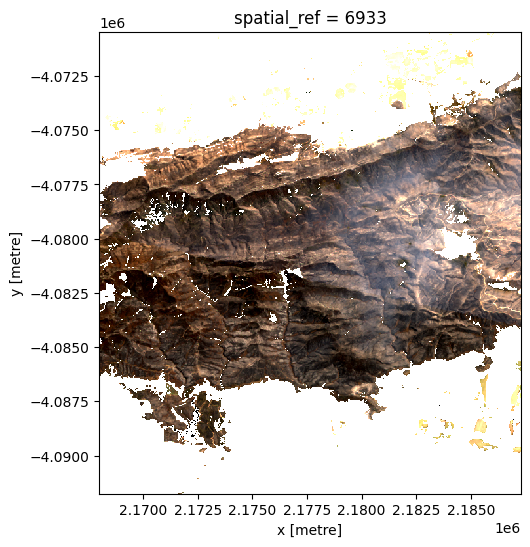

In [20]:
# Set threshold value. Fire serverity index values below this value will be masked out.
threshold = 0.25

# Apply threshold to the dNBR dataset to create the `burnt` dataset of burnt pixels
burnt = bam > threshold

# Mask real-time true colour image with the above `burnt` mask to show what has been captured as burnt area.
masked = bam.where(burnt == 1)
bands = ["red", "green", "blue"]
rgb(nrt_img.where(burnt == 1), bands=bands)

### Optional: Morphological Post-Processing
The result of our analysis may have resulted in an unacceptable amount of isolated pixels and other noisy returns. We can apply morphological operations to the binary xr dataarray ro remove this from the products and simplify the geometry of the output polygons. This step is optional, but can be useful when the analysis produces noisy and ‘speckled’ outputs.

Closing, Erosion, and Dilation operations are called below. Closing is a compound operation of a dilation followed by an erosion to remove small holes. Erosion shrinks the image pixels, helping to remove noisy and isolated returns. Dilatation extends image pixels to remove small holes and otherwise simplify the geometry of the derived polygons.

These operations are carried out using a disk structuring element. A default size of 3 pixels is used below, but this value can be altered to vary the degree of post-processing applied.

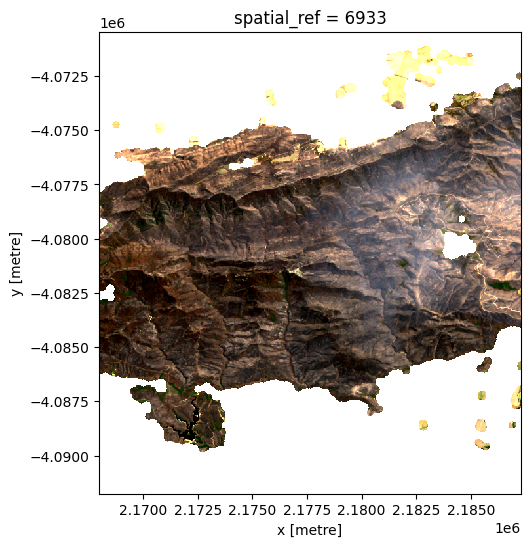

In [21]:
# Define the size of the disk structuring element, measured in number of pixels.
# The default value is 5.
disk_size = 5

# Perform the Closing, Erosion, and Dilation operations to the burnt dataarray
dilated_data = xr.DataArray(
    morphology.binary_closing(burnt, morphology.disk(disk_size)), coords=burnt.coords
)
erroded_data = xr.DataArray(
    morphology.erosion(dilated_data, morphology.disk(disk_size)), coords=burnt.coords
)
dilated_data = xr.DataArray(
    ndimage.binary_dilation(erroded_data, morphology.disk(disk_size)),
    coords=burnt.coords,
)

# Save the results to the burnt variable
burnt = dilated_data

# Visualise the post-processed dataarray to show the final burnt area
rgb(nrt_img.where(dilated_data == 1), bands=bands)


### Convert raster data to vector and export products
#### Exporting Rasters
Three rasters are exported below: 
1. An RGB geotiff of the Near Real-time imagery 
2. An RGB geotiff of the baseline imagery 
3. An unmasked single-band geotiff of the chosen delta NBR index - Those wanting to clip these images to the delineated burnt area can use the below shapefile.

In [22]:
# Set a name for the AOI (used to name exported products)
area_name = "Example"

# Write near real-time fire image to multi-band GeoTIFF
cog.write_cog(
    geo_im=nrt_img.to_array(),
    fname=f"{area_name}_{str(nrt_img.time.values)[:10]}_near_realtime_image.tif",
    overwrite=True,
)

# Write baseline reference image to multi-band GeoTIFF
cog.write_cog(
    geo_im=baseline_img.to_array(),
    fname=f"{area_name}_{str(baseline_img.time.values)[:10]}_baseline_image.tif",
    overwrite=True,
)

# Turn delta NBR into a Xarray Dataset for export to GeoTIFF
cog.write_cog(geo_im=bam, fname=f"{area_name}_{str(nrt_img.time.values)[:10]}_{bam_method}.tif", overwrite=True)

PosixPath('Example_2018-11-09_RBR.tif')

### Converting the Raster BAM data to Vector format before exporting to shapefile
We will convert the raster dataarray into vectory format using the xr_vectorize tool and export it to a shapefile. The shapefile will be visualised below.

Exporting vector data to Example_2018-11-09_RBR.shp


Text(0.5, 1.0, 'Vectorised Unverified Burnt Area Polygon for \nExample measured on 2018-11-09')

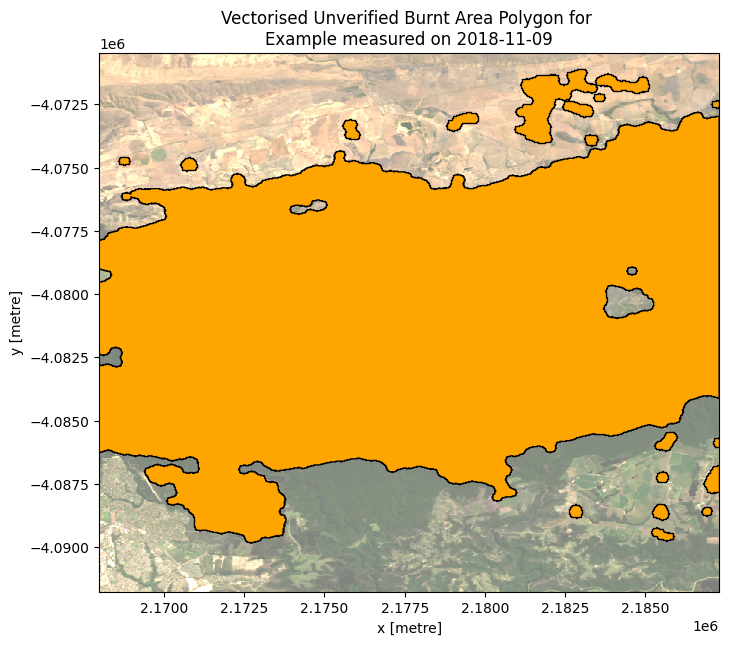

In [23]:
# Convert the burnt area from raster to vector format
gdf = xr_vectorize(
    da=burnt, mask=burnt.values == 1, output_path=f"{area_name}_{str(nrt_img.time.values)[:10]}_{bam_method}.shp"
)

# Plot the vector data overlying a transparent NRT RGB Imagery
f, ax = plt.subplots(figsize=(8, 7))

gdf.plot(edgecolor="black", color="orange", ax=ax)

rgb(nrt_img, bands=["red", "green", "blue"], ax=ax, alpha=0.5)

ax.set_title(
    f"Vectorised Unverified Burnt Area Polygon for \n{area_name} measured on "
    + str(nrt_img.time.values)[:10]
)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [24]:
print(datacube.__version__)

1.8.15


In [25]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2024-06-03'